In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import pprint
import random
import math
import seaborn as sns

import networkx as nx

In [2]:
from preprocessing import WikispeediaData
data = WikispeediaData()


<function matplotlib.pyplot.show(close=None, block=None)>

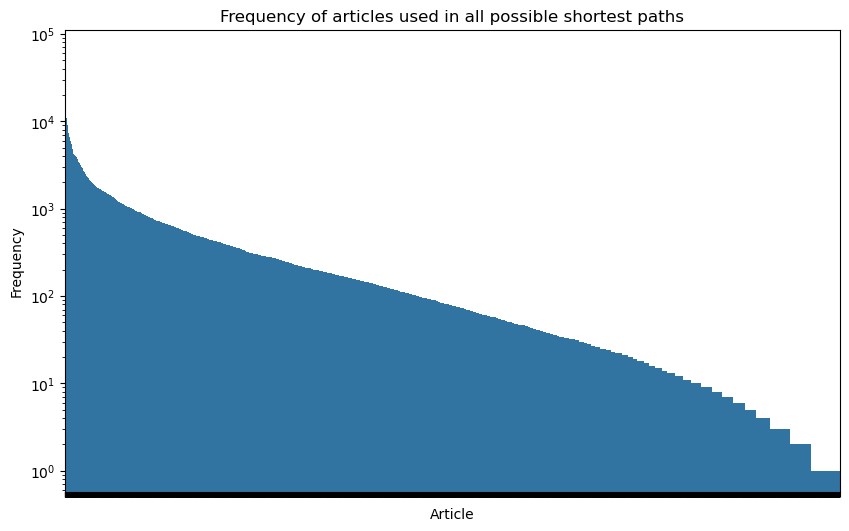

,shortest_paths,count
0,United States,64253
1,United Kingdom,29170
2,Europe,22017
3,England,18920
4,Germany,16746
...,...,...
3829,Spherical aberration,1
3830,Indian Peafowl,1
3831,Abuja,1
3832,Working poor,1


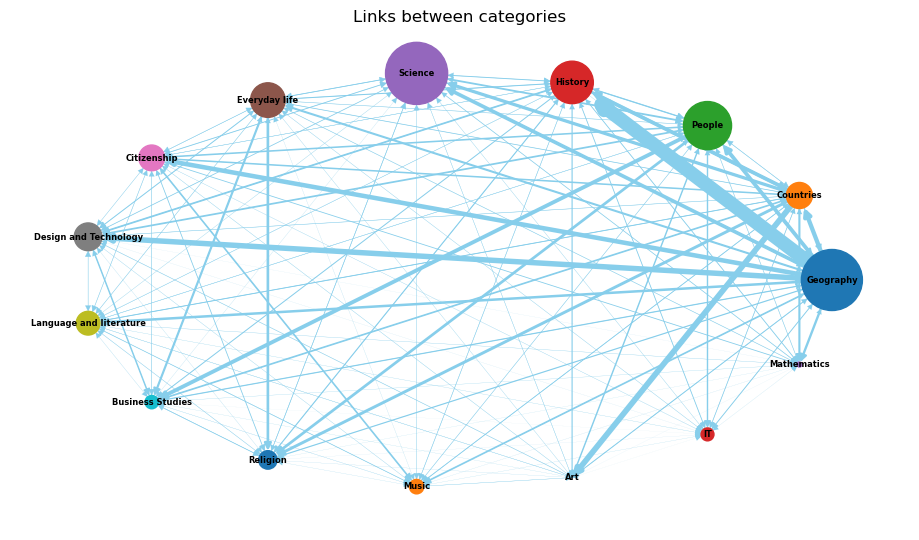

/home/viktor/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


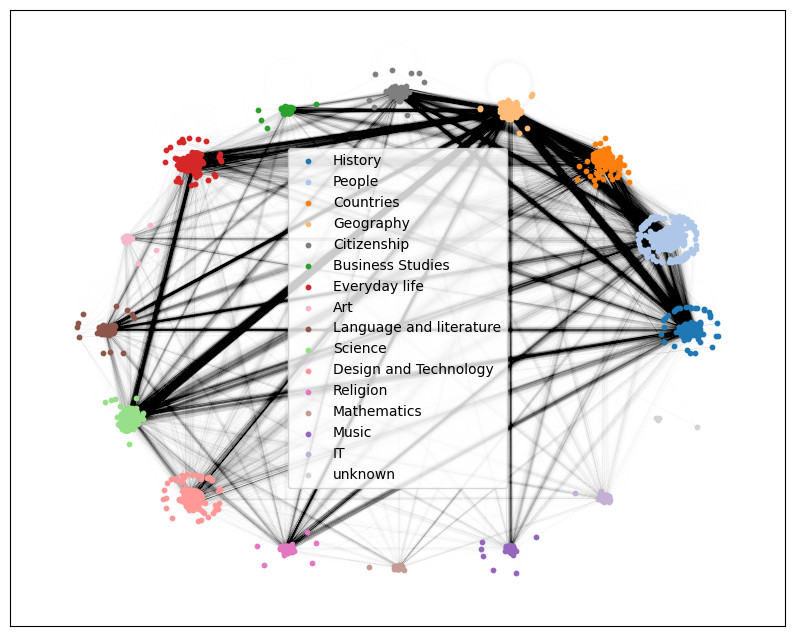

In [9]:
get_clustered_graph(data)